In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rio

# Save country data

In [2]:
# load country data from Natural Earth
country_data = gpd.read_file('../data/country_data/10m_cultural/ne_10m_admin_0_map_units.shp')

ISO_codes = country_data.ISO_A3_EH.value_counts()
country_data.loc[country_data['ISO_A3_EH'].isin(ISO_codes[ISO_codes==1].index),'SOVEREIGNT'] = country_data.loc[country_data['ISO_A3_EH'].isin(ISO_codes[ISO_codes==1].index),'NAME']


# group countries by their ISO_A3_EH code
# use ISO_A#_EH because it aggregates countries such that 99.9% of the surface area of land has an ISO ID
country_ISO_df = country_data[country_data['ISO_A3_EH'] !='-99'].sort_values('HOMEPART',ascending=False).dissolve(by='ISO_A3_EH')['SOVEREIGNT']
country_ISO_df.name= 'NAME'

# save file to csv so RECCAP regions and Pan et al. regions can be added to it
country_ISO_df.sort_values().to_csv('../data/country_data/country_iso.csv')

# Add RECCAP, Pan et al. and FAO data

In [3]:
# load data with RECCAP regions and Pan et al. regions
country_ISO_df_w_RECCAP = pd.read_csv('../data/country_data/country_iso_RECCAP_Pan.csv',index_col=0)

# load FAO country definitions
fao_country_data = pd.read_csv('../data/country_data/FAOSTAT_country_definitions.csv')
fao_country_data = fao_country_data.set_index('ISO3 Code')['Country']
fao_country_data.name = 'FAO_name'

# define final geodataframe with country data - remove data without ISO code, groupby ISO code and take name, continent and geometry
final_country_df = country_data[country_data['ISO_A3_EH'] !='-99'].sort_values('HOMEPART',ascending=False).dissolve(by='ISO_A3_EH')[['SOVEREIGNT','CONTINENT','geometry']]

# change names of columns
final_country_df.columns = ['NAME','CONTINENT','geometry']

# merge final_country_df with country_ISO_df_w_RECCAP
final_country_df = final_country_df.merge(country_ISO_df_w_RECCAP.drop(columns='NAME'), left_index=True, right_index=True, how='left')

# merge final_country_df with fao_country_data
final_country_df = final_country_df.merge(fao_country_data, left_index=True, right_index=True, how='left')

final_country_df.to_file('../data/country_data/country_data_w_RECCAP_Pan_FAO.shp')

/tmp/ipykernel_24798/3325065948.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_country_df.to_file('../data/country_data/country_data_w_RECCAP_Pan_FAO.shp')


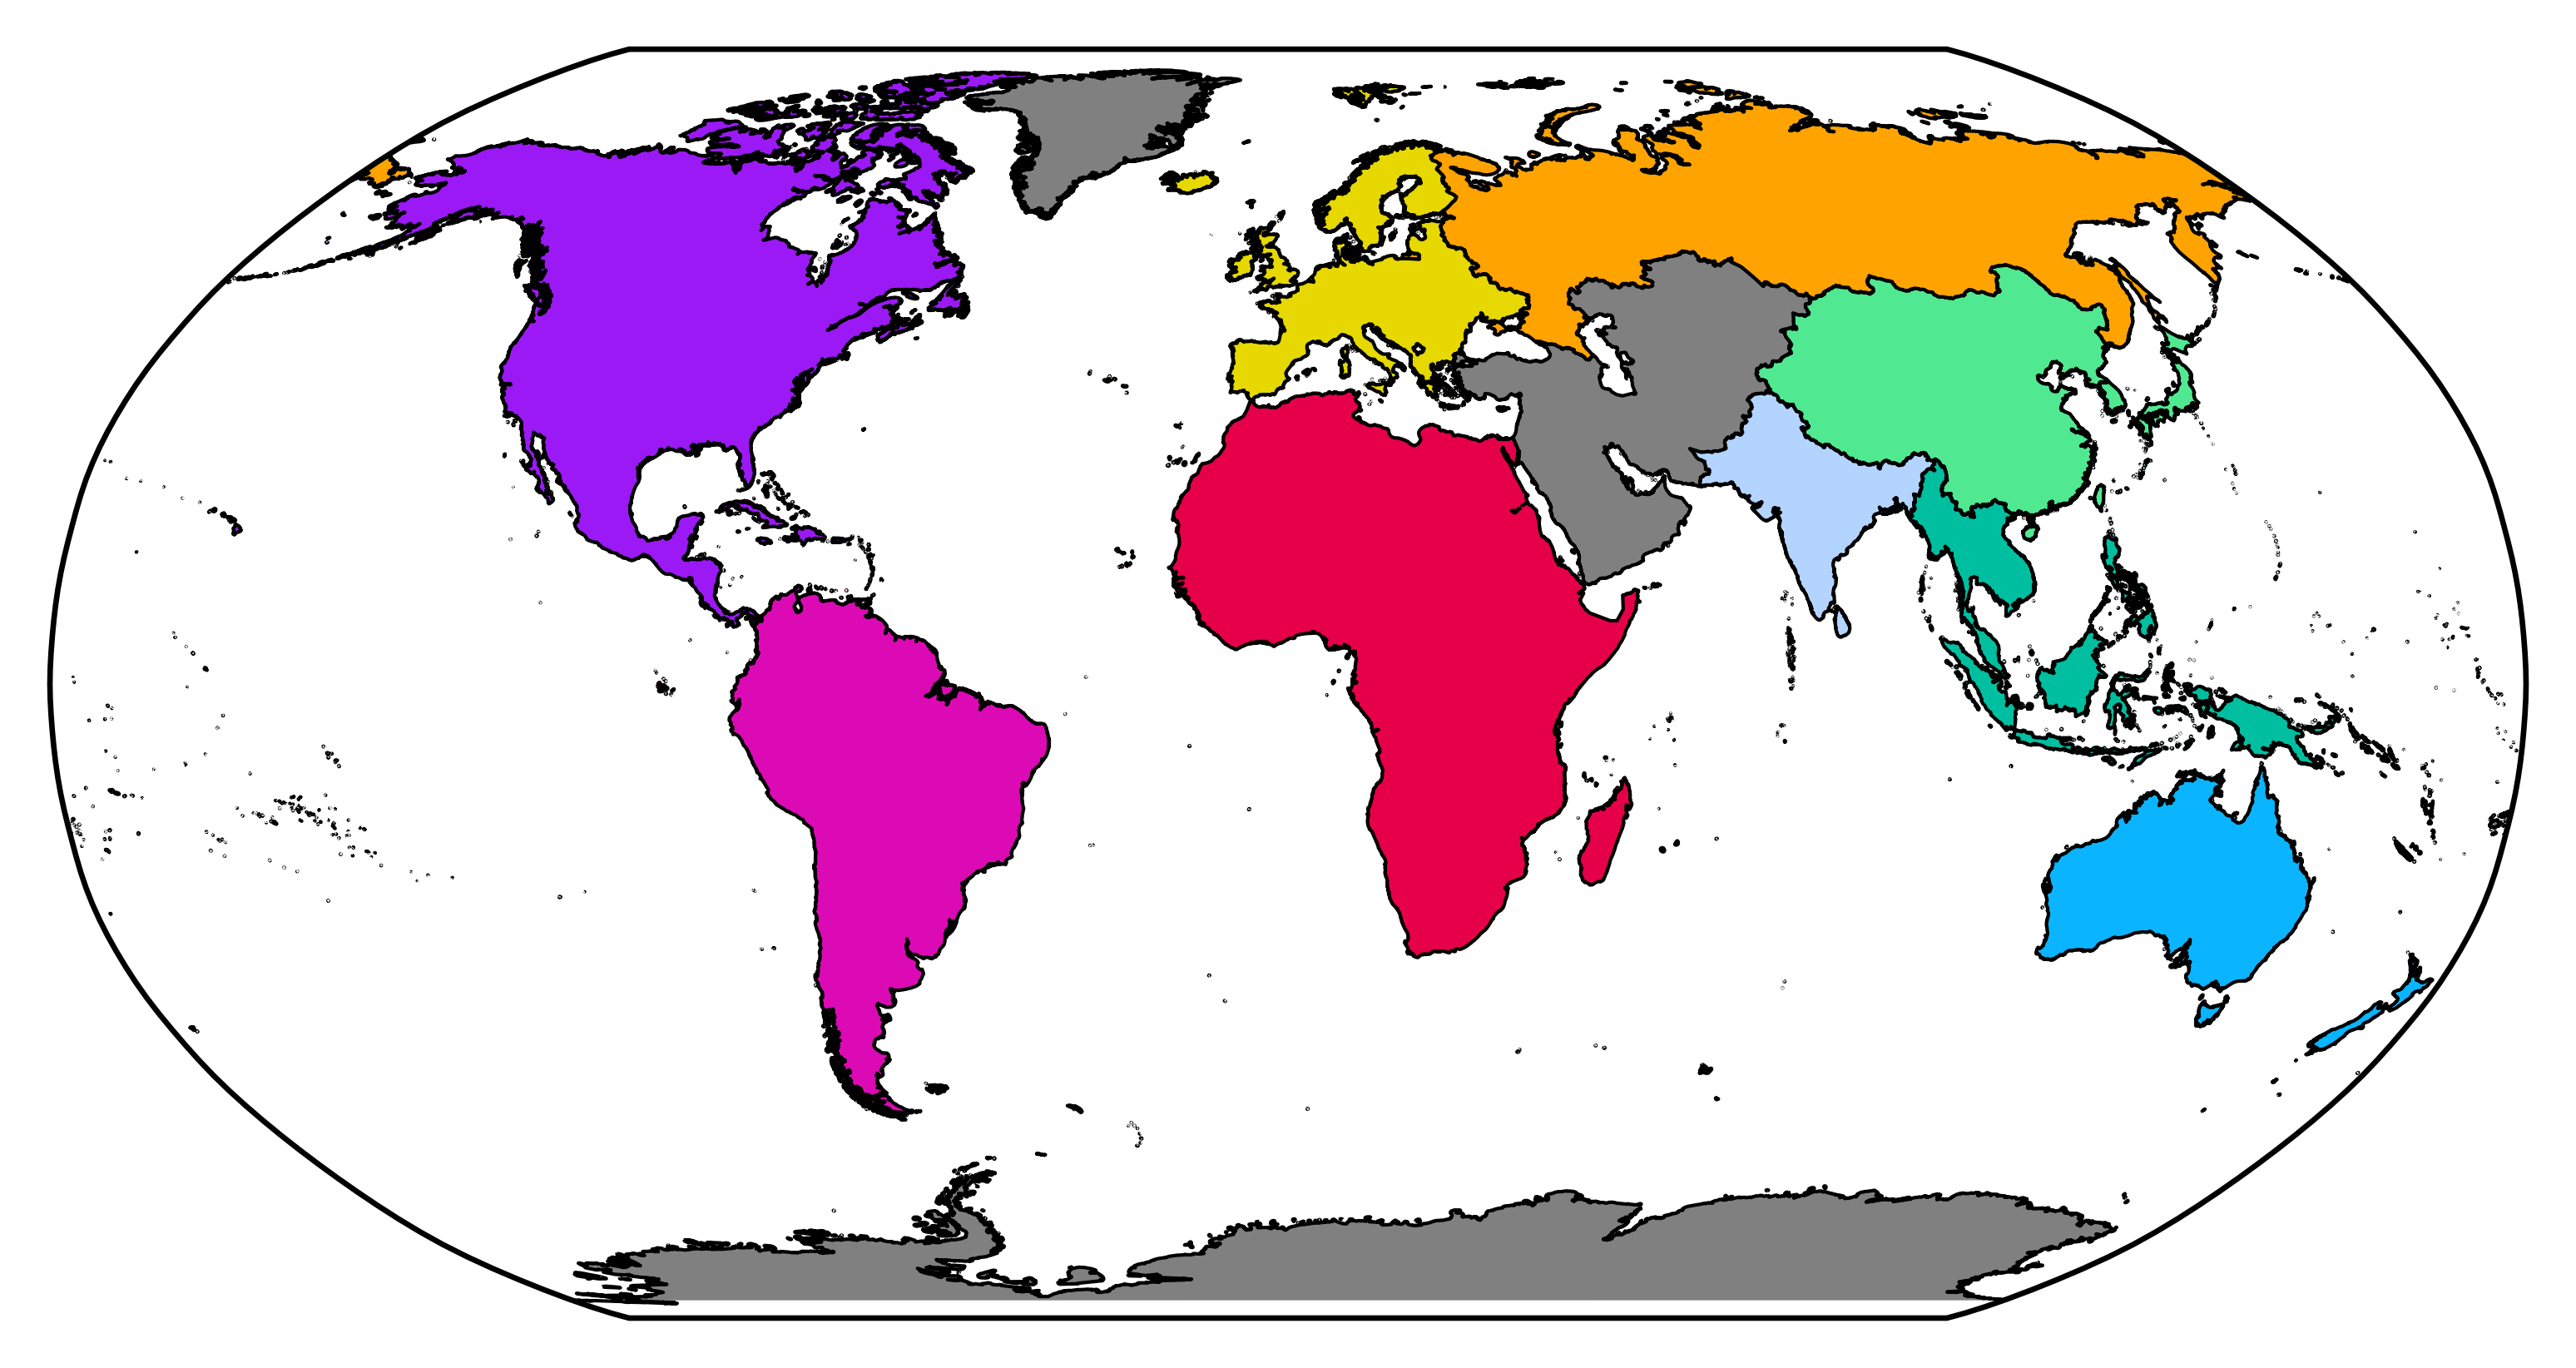

In [4]:
# plot RECCAP regions to make sure it looks OK

RECCAP = final_country_df.dissolve(by='RECCAP region')
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
fig = plt.figure(dpi=600)
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson())
cs = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5",'grey', "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]

for i,c in enumerate(cs):
        RECCAP.iloc[i:i+1].plot(facecolor=c,edgecolor='k',lw=0.5,ax=ax,transform=ccrs.PlateCarree())

# GFED regions

In [ ]:
# GFED regions
# from https://www.geo.vu.nl/~gwerf/GFED/GFED3/ancill/
GFED_regions = pd.read_csv('../data/biomass_estimates/besnard_2021/basisregions.txt',sep='   ',header=None)
GFED_regions = xr.DataArray(data=GFED_regions.values,
                    coords=[np.linspace(89.5,-89.5,360),np.linspace(-179.5,179.5,720)],
                    dims=['y','x'])
GFED_regions.rio.write_crs(rio.rioxarray.crs.CRS.from_epsg(4326),inplace=True);
GFED_regions = GFED_regions.where(GFED_regions!=0)
GFED_regions.rio.write_nodata(np.nan,inplace=True);

GFED_region_names = pd.read_excel('../data/biomass_estimates/besnard_2021/data.xlsx',sheet_name='region_names')


# WWF ecoregions

In [2]:
# Define the names of the aggregated biome names
agg_biome_name_dict = {1 : 'Tropical & Subtropical Forests'
,2 : 'Tropical & Subtropical Forests'
,3 : 'Tropical & Subtropical Forests'
,4 : 'Temperate Forests'
,5 : 'Temperate Forests'
,6 : 'Boreal Forests/Taiga'
,7 : 'Tropical & Subtropical Grasslands, Savannas & Shrublands'
,8 : 'Temperate Grasslands, Savannas & Shrublands'
,9 : 'Flooded Grasslands & Savannas'
,10 : 'Temperate Grasslands, Savannas & Shrublands'
,11 : 'Tundra'
,12 : 'Mediterranean Forests, Woodlands & Scrub'
,13 : 'Deserts & Xeric Shrublands'
,14 : 'Mangroves'}

# Load ecoregions
ecoregions = gpd.read_file('../data/regions_data/WWF_ecoregions/wwf_terr_ecos.shp')

# create a dataframe with the biome names
# biome_names = pd.DataFrame([biome_name_dict.keys(),biome_name_dict.values()],index=['BIOME','BIOME_NAME']).T
agg_biome_names = pd.DataFrame([agg_biome_name_dict.keys(),agg_biome_name_dict.values()],index=['BIOME','BIOME_NAME']).T

# merge the biome names with the ecoregions
ecoregions = ecoregions.merge(agg_biome_names,on='BIOME',how='left')

# remove ecoregions without biome name
ecoregions = ecoregions[~ecoregions.BIOME_NAME.isna()]

# group the ecoregions by biome name and realm
wwf_ecoregions = ecoregions.dissolve(by=['BIOME_NAME','REALM']).reset_index()

# add an id to the ecoregions
wwf_ecoregions['id']=range(wwf_ecoregions.shape[0])

# save aggregated WWF ecoregions
wwf_ecoregions[['BIOME_NAME','geometry','id']].to_file('../results/00_preprocessing/agg_wwf_ecoregions.shp')